<a href="https://colab.research.google.com/github/Dhyeonle9/deep-learning-practice/blob/main/231206_dl_08_cat_vs_dog_inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 필요한 라이브러리를 임포트합니다.
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Kaggle API를 사용하여 Kaggle 데이터셋을 다운로드 받기 위해 kaggle.json 파일을 업로드하고 설정하는 과정입니다.

# 'wget' 명령어를 사용하여 kaggle.json 파일을 다운로드합니다.
!wget https://raw.githubusercontent.com/BigDeepData/2312_dl/main/etc/kaggle.json

# 이미 존재하는 ~/.kaggle 디렉토리를 삭제합니다.
!rm -r ~/.kaggle

# 새로운 ~/.kaggle 디렉토리를 생성합니다.
!mkdir ~/.kaggle

# 다운로드 받은 kaggle.json 파일을 ~/.kaggle/ 디렉토리로 이동시킵니다.
!mv ./kaggle.json ~/.kaggle/

# kaggle.json 파일에 대한 권한을 변경합니다.
!chmod 600 ~/.kaggle/kaggle.json

# Kaggle API를 사용하여 데이터셋을 다운로드 받습니다.
!kaggle datasets download -d karakaggle/kaggle-cat-vs-dog-dataset

# 다운로드 받은 데이터셋을 압축 해제합니다.
!unzip kaggle-cat-vs-dog-dataset.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5489.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/549.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5490.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5491.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5492.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5493.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5494.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5495.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5496.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5497.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5498.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5499.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/55.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/550.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5500.jpg  
  inflating: kagglecatsanddogs_3367a/P

In [3]:
# 이미지 데이터 증강을 위해 ImageDataGenerator를 설정합니다.

# datagen = ImageDataGenerator(
#     rescale=1./255,                # 이미지의 픽셀 값을 0과 1 사이로 스케일링합니다.
# )
datagen = ImageDataGenerator(
    rescale=1./255,                # 이미지의 픽셀 값을 0과 1 사이로 스케일링합니다.
    rotation_range=40,             # 랜덤하게 이미지를 최대 40도 회전합니다.
    width_shift_range=0.2,         # 이미지를 수평으로 최대 20% 이동시킵니다.
    height_shift_range=0.2,        # 이미지를 수직으로 최대 20% 이동시킵니다.
    shear_range=0.2,               # 이미지를 최대 20% 기울입니다.
    zoom_range=0.2,                # 이미지를 최대 20% 확대/축소합니다.
    horizontal_flip=True,          # 수평으로 랜덤하게 이미지를 뒤집습니다.
    fill_mode='nearest',           # 회전 또는 이동으로 인해 생긴 빈 공간을 가장 가까운 픽셀로 채웁니다.
    validation_split=0.2           # 20%의 데이터를 검증(테스트)용으로 예약합니다.
)

In [4]:
# 학습 데이터셋 생성을 위해 ImageDataGenerator로부터 데이터를 생성합니다.

train_generator = datagen.flow_from_directory(
    'kagglecatsanddogs_3367a/PetImages',  # 이미지 파일이 있는 상위 디렉토리 경로를 지정합니다.
    target_size=(150, 150),              # 모든 이미지를 150x150 크기로 조정합니다.
    batch_size=32,                       # 한 번에 생성되는 이미지 배치 크기를 설정합니다.
    class_mode='binary',                 # 바이너리 분류를 수행할 것이므로 'binary'로 설정합니다.
    subset='training'                    # 'training'을 지정하여 학습용 데이터셋을 생성합니다.
)

Found 19968 images belonging to 2 classes.


In [5]:
# InceptionV3 모델 로드 (포함된 가중치와 함께, 마지막 완전 연결 층 제외)
base_model = InceptionV3(weights='imagenet', include_top=False)
# 이미지가 최종적으로 분류 대상이 되는 MLP(FC) -> 핵심

# 모델의 최상단 레이어를 추가합니다. 이 레이어는 새로운 클래스에 대한 예측을 수행합니다.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # 분류할 클래스 수에 따라 조정합니다.

87910968/87910968 [==============================] - 2s 0us/step


In [6]:
# 새로운 모델을 만듭니다.
model = Model(inputs=base_model.input, outputs=predictions)

# 기존의 InceptionV3 모델은 가중치가 이미 훈련되었으므로 미세 조정을 위해 일부 레이어를 고정합니다.
for layer in base_model.layers:
    layer.trainable = False

model.summary()  # 모델 구조를 요약하여 출력합니다.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

In [7]:
# 모델 컴파일 및 학습 설정
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [8]:
# 모델 학습
history = model.fit(train_generator, epochs=10, verbose=1)

Epoch 1/10
546/624 [=========================>....] - ETA: 19s - loss: 0.2640 - accuracy: 0.9145

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


624/624 [==============================] - 173s 251ms/step - loss: 0.2526 - accuracy: 0.9157
Epoch 2/10
624/624 [==============================] - 156s 251ms/step - loss: 0.1586 - accuracy: 0.9351
Epoch 3/10
624/624 [==============================] - 160s 256ms/step - loss: 0.1473 - accuracy: 0.9390
Epoch 4/10
624/624 [==============================] - 161s 257ms/step - loss: 0.1480 - accuracy: 0.9390
Epoch 5/10
624/624 [==============================] - 162s 260ms/step - loss: 0.1377 - accuracy: 0.9417
Epoch 6/10
624/624 [==============================] - 162s 259ms/step - loss: 0.1436 - accuracy: 0.9417
Epoch 7/10
624/624 [==============================] - 161s 258ms/step - loss: 0.1421 - accuracy: 0.9407
Epoch 8/10
624/624 [==============================] - 161s 257ms/step - loss: 0.1391 - accuracy: 0.9425
Epoch 9/10
624/624 [==============================] - 163s 261ms/step - loss: 0.1344 - accuracy: 0.9444
Epoch 10/10
624/624 [==============================] - 161s 258ms/step - lo

In [9]:
# 테스트 데이터셋을 위한 ImageDataGenerator를 설정합니다.
test_datagen = ImageDataGenerator(rescale=1./255)  # 이미지 스케일링만 수행합니다.

# 검증(테스트) 데이터셋 생성
test_generator = datagen.flow_from_directory(
    'kagglecatsanddogs_3367a/PetImages',  # 이미지 파일이 있는 상위 디렉토리 경로를 지정합니다.
    target_size=(150, 150),              # 모든 이미지를 150x150 크기로 조정합니다.
    batch_size=32,                       # 한 번에 생성되는 이미지 배치 크기를 설정합니다.
    class_mode='binary',                 # 바이너리 분류를 수행할 것이므로 'binary'로 설정합니다.
    subset='validation'                  # 'validation'을 지정하여 검증용 데이터셋을 생성합니다.
)

# 모델을 test 데이터셋으로 평가
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test 데이터셋에 대한 손실: {test_loss:.2f}")
print(f"Test 데이터셋에 대한 정확도: {test_accuracy:.2f}%")

# test_datagen: 테스트 데이터셋을 위한 ImageDataGenerator를 설정합니다.
# 여기에서는 이미지 스케일링만 수행하여 이미지의 픽셀 값을 0과 1 사이로 스케일링합니다.
# test_generator: 검증(테스트) 데이터셋을 생성합니다.
# 이 데이터셋은 이미지 파일이 있는 디렉토리에서 이미지를 로드하고, 크기를 조정하며, 배치로 나누고, 이진 분류를 위한 레이블을 생성합니다.
# model.evaluate(test_generator): 모델을 테스트 데이터셋으로 평가합니다.
# 이 함수는 테스트 데이터셋을 사용하여 손실과 정확도를 계산하고 반환합니다.
# 마지막으로 손실과 정확도를 출력하여 모델의 성능을 확인합니다.

Found 4991 images belonging to 2 classes.
156/156 [==============================] - 42s 259ms/step - loss: 0.1383 - accuracy: 0.9423
Test 데이터셋에 대한 손실: 0.14
Test 데이터셋에 대한 정확도: 0.94%


In [10]:
# 학습된 모델을 저장합니다.
model.save('my_inceptionv3_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saving 강아지1.jpg to 강아지1.jpg
Saving 강아지2.jpg to 강아지2.jpg
Saving 강아지3.jpg to 강아지3.jpg
Saving 강아지4.jpg to 강아지4.jpg
Saving 강아지5.jpg to 강아지5.jpg
Saving 강아지6.jpg to 강아지6.jpg
Saving 강아지7.jpg to 강아지7.jpg
Saving 고양이1.jpg to 고양이1.jpg
Saving 고양이2.jpg to 고양이2.jpg
Saving 고양이3.jpg to 고양이3.jpg
Saving 고양이4.jpg to 고양이4.jpg
Saving 고양이5.jpg to 고양이5.jpg
Saving 고양이6.jpg to 고양이6.jpg


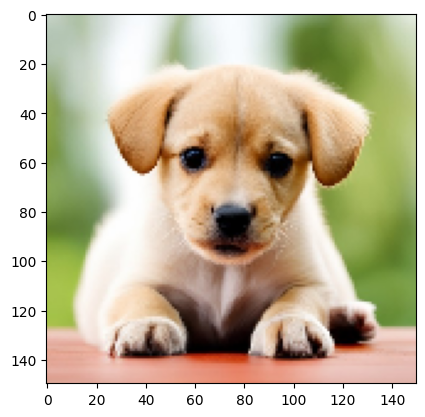

1/1 [==============================] - 2s 2s/step
[[1.]]
이미지는 개로 분류됩니다. 확률: 100.00%


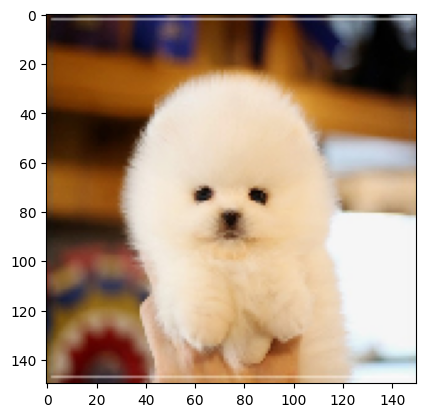

1/1 [==============================] - 0s 43ms/step
[[0.46467456]]
이미지는 고양이로 분류됩니다. 확률: 53.53%


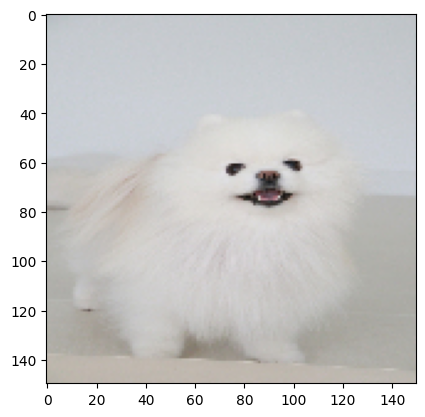

1/1 [==============================] - 0s 45ms/step
[[0.99999297]]
이미지는 개로 분류됩니다. 확률: 100.00%


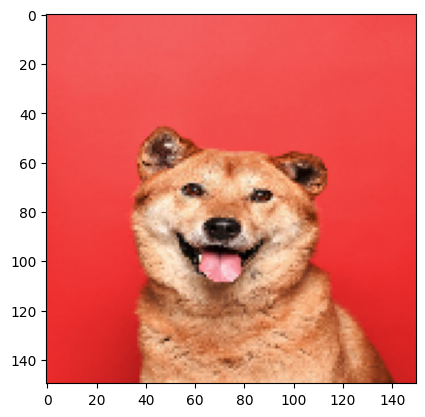

1/1 [==============================] - 0s 26ms/step
[[1.]]
이미지는 개로 분류됩니다. 확률: 100.00%


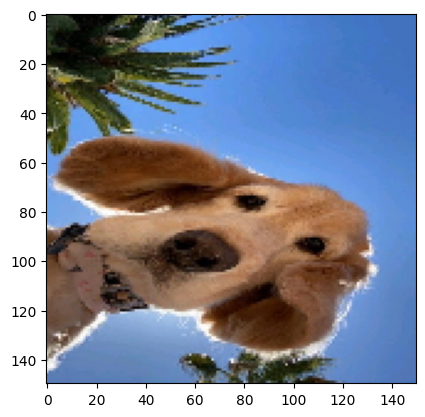

1/1 [==============================] - 0s 34ms/step
[[6.59404e-14]]
이미지는 고양이로 분류됩니다. 확률: 100.00%


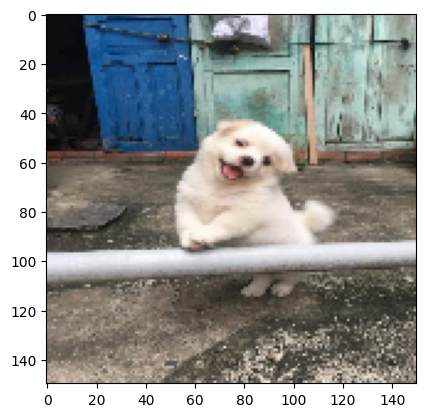

1/1 [==============================] - 0s 26ms/step
[[1.]]
이미지는 개로 분류됩니다. 확률: 100.00%


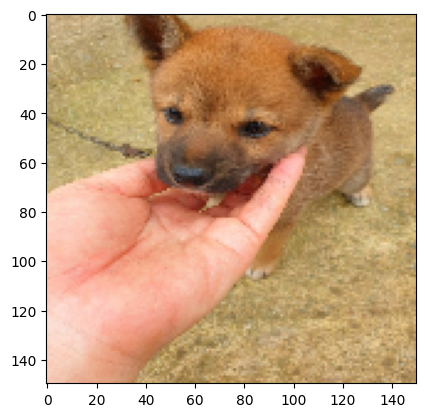

1/1 [==============================] - 0s 29ms/step
[[1.]]
이미지는 개로 분류됩니다. 확률: 100.00%


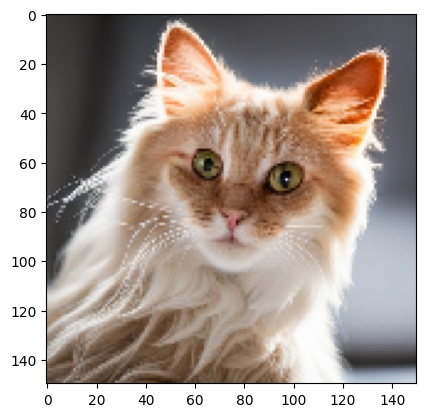

1/1 [==============================] - 0s 41ms/step
[[1.]]
이미지는 개로 분류됩니다. 확률: 100.00%


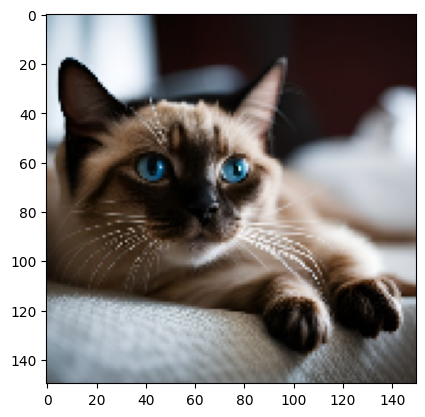

1/1 [==============================] - 0s 43ms/step
[[0.9994368]]
이미지는 개로 분류됩니다. 확률: 99.94%


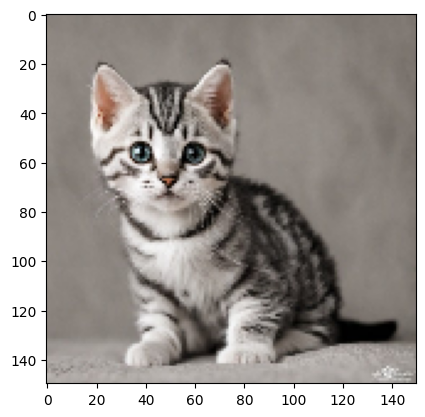

1/1 [==============================] - 0s 31ms/step
[[1.]]
이미지는 개로 분류됩니다. 확률: 100.00%


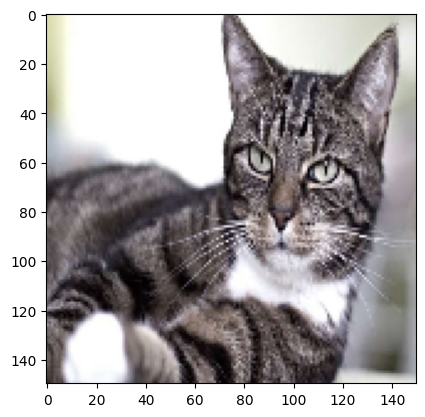

1/1 [==============================] - 0s 32ms/step
[[0.09673107]]
이미지는 고양이로 분류됩니다. 확률: 90.33%


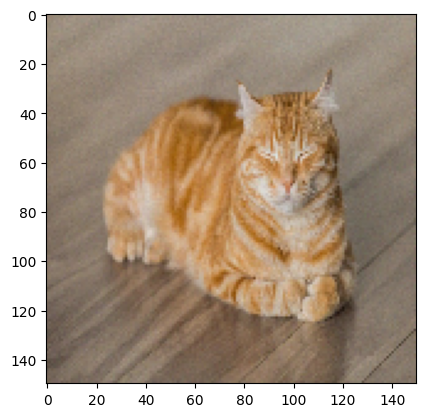

1/1 [==============================] - 0s 34ms/step
[[1.]]
이미지는 개로 분류됩니다. 확률: 100.00%


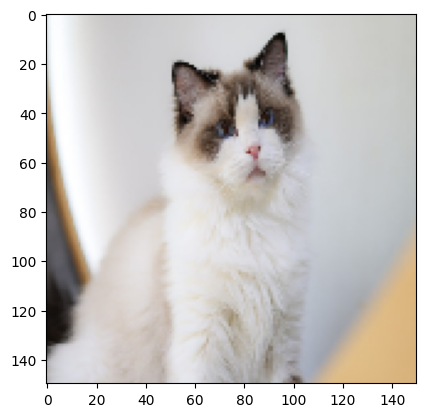

1/1 [==============================] - 0s 29ms/step
[[1.]]
이미지는 개로 분류됩니다. 확률: 100.00%


In [11]:
from google.colab import files  # Google Colab에서 파일을 업로드하고 다운로드하는 데 사용됩니다.
from keras.preprocessing import image  # 이미지 데이터를 처리하는 데 도움을 줍니다.
import matplotlib.pyplot as plt  # 그래프 및 이미지 표시를 위한 Matplotlib을 사용합니다.

# 이미지 분류 함수 정의
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(150, 150))  # 이미지를 불러와서 크기를 조정합니다.
    img_array = image.img_to_array(img)  # 이미지를 넘파이 배열로 변환합니다.
    img_array = tf.expand_dims(img_array, 0)  # 이미지를 배치로 변환합니다.

    predictions = model.predict(img_array)  # 모델을 사용하여 이미지를 분류합니다.
    score = predictions[0]
    print(predictions)
    if score > 0.5:
        print(f"이미지는 개로 분류됩니다. 확률: {100 * float(score):.2f}%")
    else:
        print(f"이미지는 고양이로 분류됩니다. 확률: {100 * float(1 - score):.2f}%")

# 이미지 업로드 및 예측
uploaded = files.upload()  # 이미지 파일을 업로드합니다.

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(150, 150))
    plt.imshow(img)
    plt.show()

    predict_image(path)  # 업로드한 이미지에 대한 예측을 수행합니다.

# predict_image(image_path): 이미지 파일의 경로를 입력으로 받아 해당 이미지를 모델을 사용하여 개 또는 고양이로 분류하는 함수입니다.
# 이미지를 로드하고 넘파이 배열로 변환한 후, 모델을 사용하여 예측을 수행하고 확률을 출력합니다.
# uploaded = files.upload(): 이미지 파일을 업로드하기 위한 코드입니다. 업로드한 이미지는 uploaded 변수에 저장됩니다.
# for fn in uploaded.keys():: 업로드한 이미지 파일을 하나씩 순회하면서 예측을 수행합니다.
# 마지막으로 업로드한 이미지를 표시하고, predict_image 함수를 호출하여 해당 이미지를 분류합니다. 결과는 확률과 함께 출력됩니다.